In [ ]:
# Trying to double-check crossover comparison approach by plotting deployment cruist o2 profiles and float o2 from deployed floats 
# Comparing to offsets from my code


In [111]:
import xarray as xr
import numpy as np
import float_data_processing as fl
import glob, os
import carbon_utils
import matplotlib.pyplot as plt
from scipy import interpolate


In [2]:
# Set the paths
output_dir = 'output/'
data_dir = 'data/'

#check directories exist
if not os.path.isdir('output'):
    os.mkdir('output')
if not os.path.isdir('data'):
    os.mkdir('data')

# Check for a glodap_offsets_plots directory, create if it does not exist
offset_dir = output_dir + 'glodap_offset_plots/'
if not os.path.isdir(offset_dir):
    os.mkdir(offset_dir)

# read in a user-created text file to point to local directories to avoid having to change this every time 
# we update code
lines=[]
with open('path_file.txt') as f:
    lines = f.readlines()
    
count = 0
for line in lines:
    count += 1
    index = line.find("=")
    #print(f'line {count}: {line}')
    #print(index)
    #print(line[0:index])
    line = line.rstrip()
    if line[0:index].find("argo")>=0:
        argo_path=line[index+1:]
    elif line[0:index].find("liar")>=0:
        liar_dir=line[index+1:]
    elif line[0:index].find("matlab")>=0:
        matlab_dir=line[index+1:]





In [6]:
gdap = fl.get_glodap(data_dir, year = 2022)
gdap.G2longitude[gdap.G2longitude < 0.] = gdap.G2longitude[gdap.G2longitude < 0.] + 360.
#set flagged data to NaN (is this needed? or masked array better?)
flagvars = ['G2salinity','G2oxygen','G2nitrate','G2tco2','G2talk','G2phts25p0']

for v in flagvars:
    flag = v+'f'
    naninds = gdap[flag]!=2
    gdap[v][naninds] = np.nan

# GLODAP derived variables: density, MLD and pH

#calc potential density
gdap['sigma0_calculated'] = carbon_utils.sigma0(gdap.G2salinity.values,gdap.G2temperature.values,
                                  gdap.G2longitude.values,gdap.G2latitude.values,gdap.G2pressure.values)
#calculate spice
gdap['spice'] = carbon_utils.spiciness0(gdap.G2salinity.values,gdap.G2temperature.values,
                                  gdap.G2longitude.values,gdap.G2latitude.values,gdap.G2pressure.values)

#rename GLODAP comparison variables to match argo
gdap = gdap.rename(columns={'G2longitude':'LONGITUDE', 'G2latitude':'LATITUDE', 'G2pressure':'PRES_ADJUSTED',
                            'G2temperature':'TEMP_ADJUSTED','G2salinity':'PSAL_ADJUSTED', 
                            'G2oxygen':'DOXY_ADJUSTED','G2nitrate':'NITRATE_ADJUSTED', 'G2tco2':'DIC', 
                            'G2talk':'TALK_LIAR', 'G2MLD':'MLD','G2o2sat':'o2sat', 'G2PTMP':'PTMP', 
                            'sigma0_calculated':'PDENS'})

gdap['obs_index']=gdap.reset_index().index

https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0257247/GLODAPv2.2022_Merged_Master_File.csv


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/float_data_processing.py:36: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gdap = pd.read_csv(save_dir+'GLODAPv2.'+str(year)+'_Merged_Master_File.csv')
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_84863/2935541068.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdap.G2longitude[gdap.G2longitude < 0.] = gdap.G2longitude[gdap.G2longitude < 0.] + 360.
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_84863/2935541068.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [83]:
# Find glodap cruise
cruise_expo = '320620180309'

# print(gdap['G2expocode'])
# expo_index = gdap['G2expocode']==cruise_expo
gdap['G2expocode'] = gdap['G2expocode'].astype(str) # need to force all expocodes to be strings
# print(expo_str)
expo_index = gdap['G2expocode'].str.contains(cruise_expo, case=False, na=False)
unique_matches = np.unique(gdap['G2expocode'][expo_index])

print(unique_matches)
gdap_cruise = gdap[expo_index]

['320620180309']


,G2expocode,G2cruise,G2station,G2region,G2cast,G2year,G2month,G2day,G2hour,G2minute,...,G2donf,G2tdn,G2tdnf,G2chla,G2chlaf,G2doi,datetime,PDENS,spice,obs_index
1313460,320620180309,3031,1.0,8,1,2018,3,17,2,11,...,9,-9999.0,9,-9999.0,9,https://doi.org/10.25921/8arx-2058 ...,2018-03-17 02:11:00,27.418811,-0.733532,1313460
1313461,320620180309,3031,1.0,8,1,2018,3,17,2,11,...,9,32.1,2,-9999.0,9,https://doi.org/10.25921/8arx-2058 ...,2018-03-17 02:11:00,27.447643,-0.708969,1313461
1313462,320620180309,3031,1.0,8,1,2018,3,17,2,11,...,9,29.9,2,-9999.0,9,https://doi.org/10.25921/8arx-2058 ...,2018-03-17 02:11:00,27.470034,-0.681442,1313462
1313463,320620180309,3031,1.0,8,1,2018,3,17,2,11,...,9,31.8,2,-9999.0,9,https://doi.org/10.25921/8arx-2058 ...,2018-03-17 02:11:00,27.482489,-0.669675,1313463
1313464,320620180309,3031,1.0,8,1,2018,3,17,2,11,...,9,31.1,2,-9999.0,9,https://doi.org/10.25921/8arx-2058 ...,2018-03-17 02:11:00,27.507713,-0.637361,1313464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317634,320620180309,3031,901.0,8,1,2018,3,14,0,25,...,9,-9999.0,9,-9999.0,9,https://doi.org/10.25921/8arx-2058 ...,2018-03-14 00:25:00,27.792430,-0.052303,1317634
1317635,320620180309,3031,901.0,8,1,2018,3,14,0,25,...,9,-9999.0,9,-9999.0,9,https://doi.org/10.25921/8arx-2058 ...,2018-03-14 00:25:00,27.805141,-0.068082,1317635
1317636,320620180309,3031,901.0,8,1,2018,3,14,0,25,...,9,-9999.0,9,-9999.0,9,https://doi.org/10.25921/8arx-2058 ...,2018-03-14 00:25:00,27.805142,-0.068082,1317636
1317637,320620180309,3031,901.0,8,1,2018,3,14,0,25,...,9,-9999.0,9,-9999.0,9,https://doi.org/10.25921/8arx-2058 ...,2018-03-14 00:25:00,27.805146,-0.068085,1317637


In [41]:
argo_list = [5905634,5905638,5905635,5905637,5905636]
argo_n = xr.open_dataset(argo_path + str(argo_list[0]) + '_Sprof.nc')

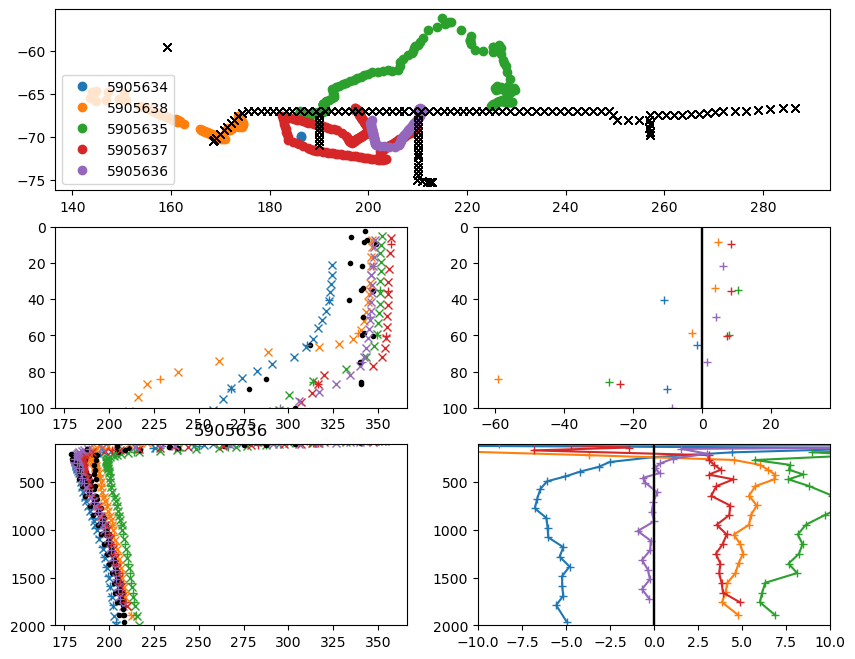

In [173]:
# plot data on a map
fig = plt.figure(figsize=(10,8))

for argo in argo_list:
    argo_n = xr.open_dataset(argo_path + str(argo) + '_Sprof.nc')

    temp_longitude = argo_n.LONGITUDE
    temp_longitude[temp_longitude<0] = temp_longitude[temp_longitude<0]+360
    plt.subplot(3,2,(1, 2))
    line, = plt.plot(temp_longitude, argo_n.LATITUDE, 'o', label=argo)
    line_color = line.get_color()
    plt.plot(gdap_cruise.LONGITUDE, gdap_cruise.LATITUDE,'xk')
    plt.legend()

    time_diff = abs(argo_n.JULD[0].values - gdap_cruise.datetime.values)
    # print(time_diff)
    closest_index = np.argmin(time_diff)
    # print(closest_index)
    closest_datetime = gdap_cruise.loc[:, 'datetime'].values[closest_index]
    time_match = gdap_cruise.datetime==closest_datetime

    # interpolate the Argo data to gdap_cruise_pressures
    p_interp = gdap_cruise.PRES_ADJUSTED[time_match].values

    p100 = argo_n.PRES_ADJUSTED[0,:]
    var100 = argo_n.DOXY_ADJUSTED[0,:]


    # Remove NaN values from p100 and var100
    valid_indices = ~np.isnan(var100.values)
    p100_valid = p100[valid_indices]
    var100_valid = var100[valid_indices]

    # Check if there are non-unique pressure values
    if len(p100_valid) > len(np.unique(p100_valid)):
        unique_indices = np.unique(p100_valid, return_index=True)[1]
        p100_valid = p100_valid[unique_indices]
        var100_valid = var100_valid[unique_indices]

    # Check if p_interp values are within the interpolation range
    valid_interp_indices = np.where((p_interp >= np.min(p100_valid).values) & (p_interp <= np.max(p100_valid).values))


    f = interpolate.interp1d(p100_valid, var100_valid)
    var_interp_p = f(p_interp[valid_interp_indices])

    # print(f"Corresponding datetime in gdap: {closest_datetime}")
    # print(argo_n.JULD[0].values)
    axn = plt.subplot(3,2,3)
    plt.plot(argo_n.DOXY_ADJUSTED[0,:], argo_n.PRES_ADJUSTED[0,:],'x', color=line_color)
    plt.plot(gdap_cruise.DOXY_ADJUSTED[time_match], gdap_cruise.PRES_ADJUSTED[time_match], 'k.')
    plt.plot(var_interp_p, p_interp[valid_interp_indices], '+', color=line_color)
    plt.gca().set_ylim([100, 0])
    # plt.gca().invert_yaxis()

    # interpolate float data to glodap, plot difference
    # plt.title(argo)

    plt.subplot(3,2,4)
    offset = var_interp_p - gdap_cruise.DOXY_ADJUSTED[time_match].values[valid_interp_indices]
    plt.plot(offset, p_interp[valid_interp_indices], '+', color=line_color)
    plt.gca().set_ylim([100, 0])
    plt.axvline(x=0, color='k')


    axn = plt.subplot(3,2,5)
    plt.plot(argo_n.DOXY_ADJUSTED[0,:], argo_n.PRES_ADJUSTED[0,:],'x', color=line_color)
    plt.plot(gdap_cruise.DOXY_ADJUSTED[time_match], gdap_cruise.PRES_ADJUSTED[time_match], 'k.')
    plt.plot(var_interp_p, p_interp[valid_interp_indices], '+', color=line_color)
    plt.gca().set_ylim([2000, 100])
    # plt.gca().invert_yaxis()

    # interpolate float data to glodap, plot difference
    plt.title(argo)

    plt.subplot(3,2,6)
    offset = var_interp_p - gdap_cruise.DOXY_ADJUSTED[time_match].values[valid_interp_indices]
    plt.plot(offset, p_interp[valid_interp_indices], '+-', color=line_color)
    plt.gca().set_ylim([2000, 100])
    plt.gca().set_xlim([-10, 10])
    plt.axvline(x=0, color='k')
    

In [142]:
var_interp_p

array([347.46453856, 345.76441867, 341.26754963, 295.10214366,
       229.50492384, 188.95071574, 181.81881176, 180.47081083,
       181.86116703, 183.14778322, 184.01162861, 184.77504205,
       185.7992979 , 188.9722218 , 191.35794655, 193.66819779,
       195.80106221, 197.46959864, 199.31336782, 200.77434946,
       202.01197046, 203.24999062, 203.96461676, 204.91266057,
       206.23225793])

In [139]:
gdap_cruise.PRES_ADJUSTED[time_match].values

array([   7.4,   21.5,   49.6,   74.6,  100.3,  124.6,  150.4,  201.1,
        251.9,  301.9,  352.3,  403.6,  453.6,  504.1,  606.6,  707.3,
        808.5,  910.1, 1011.8, 1113.3, 1214.6, 1316. , 1417.4, 1518.2,
       1621.3, 1723.7, 1825.7, 2054.7, 2308.8, 2564.7, 2820.3, 3077.1,
       3385. , 3693.6, 4001.1, 4205.9])

In [129]:
p_interp >= np.min(p100_valid)

ValueError: applied function returned data with unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names: ()

In [135]:
np.min(p100_valid).values

array(7.5)

In [122]:
print(p100[~np.isnan(var100.values)])


<xarray.DataArray 'PRES_ADJUSTED' (N_LEVELS: 68)>
array([   7.5     ,   11.33    ,   16.54    ,   21.5     ,   26.92    ,
         31.939999,   36.73    ,   41.84    ,   46.49    ,   51.58    ,
         56.53    ,   61.64    ,   66.93    ,   72.      ,   76.95    ,
         81.840004,   86.73    ,   91.13    ,   96.05    ,  101.78    ,
        111.12    ,  121.3     ,  131.45    ,  141.3     ,  151.77    ,
        161.53    ,  171.2     ,  181.26    ,  191.11    ,  200.88    ,
        211.26    ,  221.56    ,  231.04    ,  240.96    ,  249.74    ,
        258.91998 ,  271.25998 ,  281.56    ,  291.41998 ,  301.34    ,
        311.62    ,  321.21    ,  331.40997 ,  341.81998 ,  351.52    ,
        361.25    ,  381.37997 ,  400.59    ,  450.99    ,  500.96997 ,
        551.41    ,  601.81995 ,  651.63    ,  701.17    ,  751.06    ,
        800.8     ,  851.48    ,  901.72    ,  951.73    ,  999.27997 ,
       1099.14    , 1199.26    , 1299.2     , 1399.99    , 1499.6799  ,
       1599.57

1315839       7.4
1315840      21.5
1315841      49.6
1315842      74.6
1315843     100.3
1315844     124.6
1315845     150.4
1315846     201.1
1315847     251.9
1315848     301.9
1315849     352.3
1315850     403.6
1315851     453.6
1315852     504.1
1315853     606.6
1315854     707.3
1315855     808.5
1315856     910.1
1315857    1011.8
1315858    1113.3
1315859    1214.6
1315860    1316.0
1315861    1417.4
1315862    1518.2
1315863    1621.3
1315864    1723.7
1315865    1825.7
1315866    2054.7
1315867    2308.8
1315868    2564.7
1315869    2820.3
1315870    3077.1
1315871    3385.0
1315872    3693.6
1315873    4001.1
1315874    4205.9
Name: PRES_ADJUSTED, dtype: float64